# Gross Range 

### Purpose
This notebook assess how well the QARTOD gross range test, as implemented by OOI, performs with respect to accurately flagging practical salinity data from the mid-water-column in the Irminger Sea with respect to a long-term freshening signal.

In [1]:
import sys, os
import yaml
import json
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import gc
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import the QARTOD test fitting
sys.path.append("/home/andrew/Documents/OOI-CGSN/oceanobservatories/ooi-data-explorations/python/ooi_data_explorations/")
from qartod import gross_range, climatology

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Connect to OOI Data Explorer ERDDAP Server

In [5]:
from erddapy import ERDDAP
# Connect to the server
erd = ERDDAP(
    server="https://erddap.dataexplorer.oceanobservatories.org/erddap",
    protocol="tabledap"
)

#### Set OOINet API access
In order access and download data from OOINet, need to have an OOINet api username and access token. Those can be found on your profile after logging in to OOINet. Your username and access token should NOT be stored in this notebook/python script (for security). It should be stored in a yaml file, kept in the same directory, named user_info.yaml.

In [2]:
# Import the OOINet M2M tool
sys.path.append("/home/andrew/Documents/OOI-CGSN/ooinet/ooinet/")
from m2m import M2M

In [6]:
userinfo = yaml.load(open("../../../../QAQC_Sandbox/user_info.yaml"))
username = userinfo["apiname"]
token = userinfo["apikey"]

In [7]:
OOINet = M2M(username, token)

---
## Identify Datasets
Identify all of the OOI **```CTD```** datasets that are located at the Global Irminger Array on the Apex Surface Mooring, Flanking Mooring A, and Flanking Mooring B. This is done by querying OOINet and iteratively walking through all of the API endpoints. Additionally, we request the **vocab** associated with each dataset in order to get their deployed depth.

#### Irminger Sea SUMO CTDs

In [8]:
gi01sumo_datasets = OOINet.search_datasets(array="GI01SUMO", instrument="CTD", English_names=True)

# Get the instrument deployment depth
depths = pd.DataFrame()
for refdes in gi01sumo_datasets["refdes"]:
    vocab = OOINet.get_vocab(refdes)
    depths = depths.append({
        "refdes": refdes,
        "depth" : int(vocab["mindepth"])
    }, ignore_index=True)

# Merge the deployment depth with the datasets
gi01sumo_datasets = gi01sumo_datasets.merge(depths, how="left", left_on=["refdes"], right_on=["refdes"])
gi01sumo_datasets = gi01sumo_datasets.sort_values(by="depth")
gi01sumo_datasets

https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GI01SUMO


,array,array_name,node,node_name,instrument,instrument_name,refdes,url,deployments,depth
15,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RID16,Near Surface Instrument Frame,03-CTDBPF000,CTD,GI01SUMO-RID16-03-CTDBPF000,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",12.0
11,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDMOQ011,CTD (20 meters),GI01SUMO-RII11-02-CTDMOQ011,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",20.0
4,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDMOQ031,CTD (40 meters),GI01SUMO-RII11-02-CTDMOQ031,https://ooinet.oceanobservatories.org/api/m2m/...,[1],40.0
14,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP031,CTD (40 meters),GI01SUMO-RII11-02-CTDBPP031,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4, 5, 6, 7, 8]",40.0
10,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDMOQ012,CTD (60 meters),GI01SUMO-RII11-02-CTDMOQ012,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",60.0
13,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP032,CTD (80 meters),GI01SUMO-RII11-02-CTDBPP032,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4, 5, 6, 7, 8]",80.0
9,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDMOQ013,CTD (100 meters),GI01SUMO-RII11-02-CTDMOQ013,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",100.0
3,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDMOQ033,CTD (130 meters),GI01SUMO-RII11-02-CTDMOQ033,https://ooinet.oceanobservatories.org/api/m2m/...,[1],130.0
12,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP033,CTD (130 meters),GI01SUMO-RII11-02-CTDBPP033,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4, 5, 6, 7, 8]",130.0
8,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDMOQ014,CTD (180 meters),GI01SUMO-RII11-02-CTDMOQ014,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",180.0


In [9]:
gi01sumo_datasets.to_csv("../results/GI01SUMO_datasets.csv", index=False)

#### Irminger Sea Flanking Mooring A (FLMA) CTD Datasets

In [10]:
gi03flma_datasets = OOINet.search_datasets(array="GI03FLMA", instrument="CTD", English_names=True)

# Get the instrument deployment depth
depths = pd.DataFrame()
for refdes in gi03flma_datasets["refdes"]:
    check = gi03flma_datasets[gi03flma_datasets["refdes"] == refdes]["array_name"]
    if check.values[0] == "No record":
        continue
    vocab = OOINet.get_vocab(refdes)
    depths = depths.append({
        "refdes": refdes,
        "depth" : int(vocab["mindepth"])
    }, ignore_index=True)

# Merge the deployment depth with the datasets
gi03flma_datasets = gi03flma_datasets.merge(depths, how="left", left_on=["refdes"], right_on=["refdes"])
gi03flma_datasets = gi03flma_datasets.sort_values(by="depth")
gi03flma_datasets

https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GI03FLMA


,array,array_name,node,node_name,instrument,instrument_name,refdes,url,deployments,depth
16,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOG040,CTD (30 meters),GI03FLMA-RIM01-02-CTDMOG040,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",30.0
15,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOG041,CTD (40 meters),GI03FLMA-RIM01-02-CTDMOG041,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",40.0
14,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOG042,CTD (60 meters),GI03FLMA-RIM01-02-CTDMOG042,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",60.0
13,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOG043,CTD (90 meters),GI03FLMA-RIM01-02-CTDMOG043,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",90.0
12,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOG044,CTD (130 meters),GI03FLMA-RIM01-02-CTDMOG044,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",130.0
11,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOG045,CTD (180 meters),GI03FLMA-RIM01-02-CTDMOG045,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",180.0
10,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOG046,CTD (250 meters),GI03FLMA-RIM01-02-CTDMOG046,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",250.0
9,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOG047,CTD (350 meters),GI03FLMA-RIM01-02-CTDMOG047,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",350.0
8,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOG048,CTD (500 meters),GI03FLMA-RIM01-02-CTDMOG048,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",500.0
6,GI03FLMA,Global Irminger Sea Flanking Subsurface Mooring A,RIM01,Mooring Riser,02-CTDMOH049,CTD (750 meters),GI03FLMA-RIM01-02-CTDMOH049,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",750.0


In [11]:
mask = gi03flma_datasets["array_name"].apply(lambda x: False if "No record" in x else True)
gi03flma_datasets = gi03flma_datasets[mask]

In [12]:
gi03flma_datasets.to_csv("../results/GI03FLMA_datasets.csv", index=False)

#### Argentine Basin Flanking Mooring B (FLMB) CTDs

In [13]:
gi03flmb_datasets = OOINet.search_datasets(array="GI03FLMB", instrument="CTD", English_names=True)

# Get the instrument deployment depth
depths = pd.DataFrame()
for refdes in gi03flmb_datasets["refdes"]:
    check = gi03flmb_datasets[gi03flmb_datasets["refdes"] == refdes]["array_name"]
    if check.values[0] == "No record":
        continue
    vocab = OOINet.get_vocab(refdes)
    depths = depths.append({
        "refdes": refdes,
        "depth" : int(vocab["mindepth"])
    }, ignore_index=True)

# Merge the deployment depth with the datasets
gi03flmb_datasets = gi03flmb_datasets.merge(depths, how="left", left_on=["refdes"], right_on=["refdes"])
gi03flmb_datasets = gi03flmb_datasets.sort_values(by="depth")
gi03flmb_datasets

https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GI03FLMB


,array,array_name,node,node_name,instrument,instrument_name,refdes,url,deployments,depth
11,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOG060,CTD (30 meters),GI03FLMB-RIM01-02-CTDMOG060,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",30.0
10,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOG061,CTD (40 meters),GI03FLMB-RIM01-02-CTDMOG061,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",40.0
9,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOG062,CTD (60 meters),GI03FLMB-RIM01-02-CTDMOG062,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",60.0
8,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOG063,CTD (90 meters),GI03FLMB-RIM01-02-CTDMOG063,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",90.0
7,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOG064,CTD (130 meters),GI03FLMB-RIM01-02-CTDMOG064,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",130.0
6,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOG065,CTD (180 meters),GI03FLMB-RIM01-02-CTDMOG065,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",180.0
5,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOG066,CTD (250 meters),GI03FLMB-RIM01-02-CTDMOG066,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",250.0
4,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOG067,CTD (350 meters),GI03FLMB-RIM01-02-CTDMOG067,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",350.0
3,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOG068,CTD (500 meters),GI03FLMB-RIM01-02-CTDMOG068,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",500.0
2,GI03FLMB,Global Irminger Sea Flanking Subsurface Mooring B,RIM01,Mooring Riser,02-CTDMOH069,CTD (750 meters),GI03FLMB-RIM01-02-CTDMOH069,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8]",750.0


In [14]:
mask = gi03flmb_datasets["array_name"].apply(lambda x: False if "No record" in x else True)
gi03flmb_datasets = gi03flmb_datasets[mask]

In [15]:
gi03flmb_datasets.to_csv("../results/GI03FLMB_datasets.csv", index=False)

---
## Data
The next step is to get the fetch the data from each of the datasets identified above. For this notebook, we're going to request, access, and open the CTD data from the OOI DataExplorer ERDDAP server using the **```ERDDAPY```** python package (https://github.com/ioos/erddapy). We'll save each dataset into a dictionary keyed with the dataset reference designator.

First, import the sklearn **```LinearRegression```** package to fit the long-term freshening signal

In [23]:
from sklearn.linear_model import LinearRegression

In [28]:
def calculate_std(Y, yhat):
    
    n = len(Y)
    difY = Y - yhat
    se = np.sum(difY**2)/n
    std = np.sqrt(se)
    return std

#### GI01SUMO

In [24]:
gi01sumo = dict.fromkeys(gi01sumo_datasets["refdes"])
for refdes in gi01sumo_datasets["refdes"]:
    datasets = pd.read_csv(erd.get_search_url(search_for=refdes.lower(), response="csv"))["Dataset ID"]
    dset = datasets.iloc[0]
    erd.dataset_id = dset
    data = erd.to_xarray()
    data = data.swap_dims({"obs":"time"})
    gi01sumo[refdes] = data

Next, we want to plot and explore the data to identify useful datasets for this analysis

In [25]:
nfigs = len(gi01sumo.keys())
nrows = np.ceil(nfigs / 2)
ncols = 2

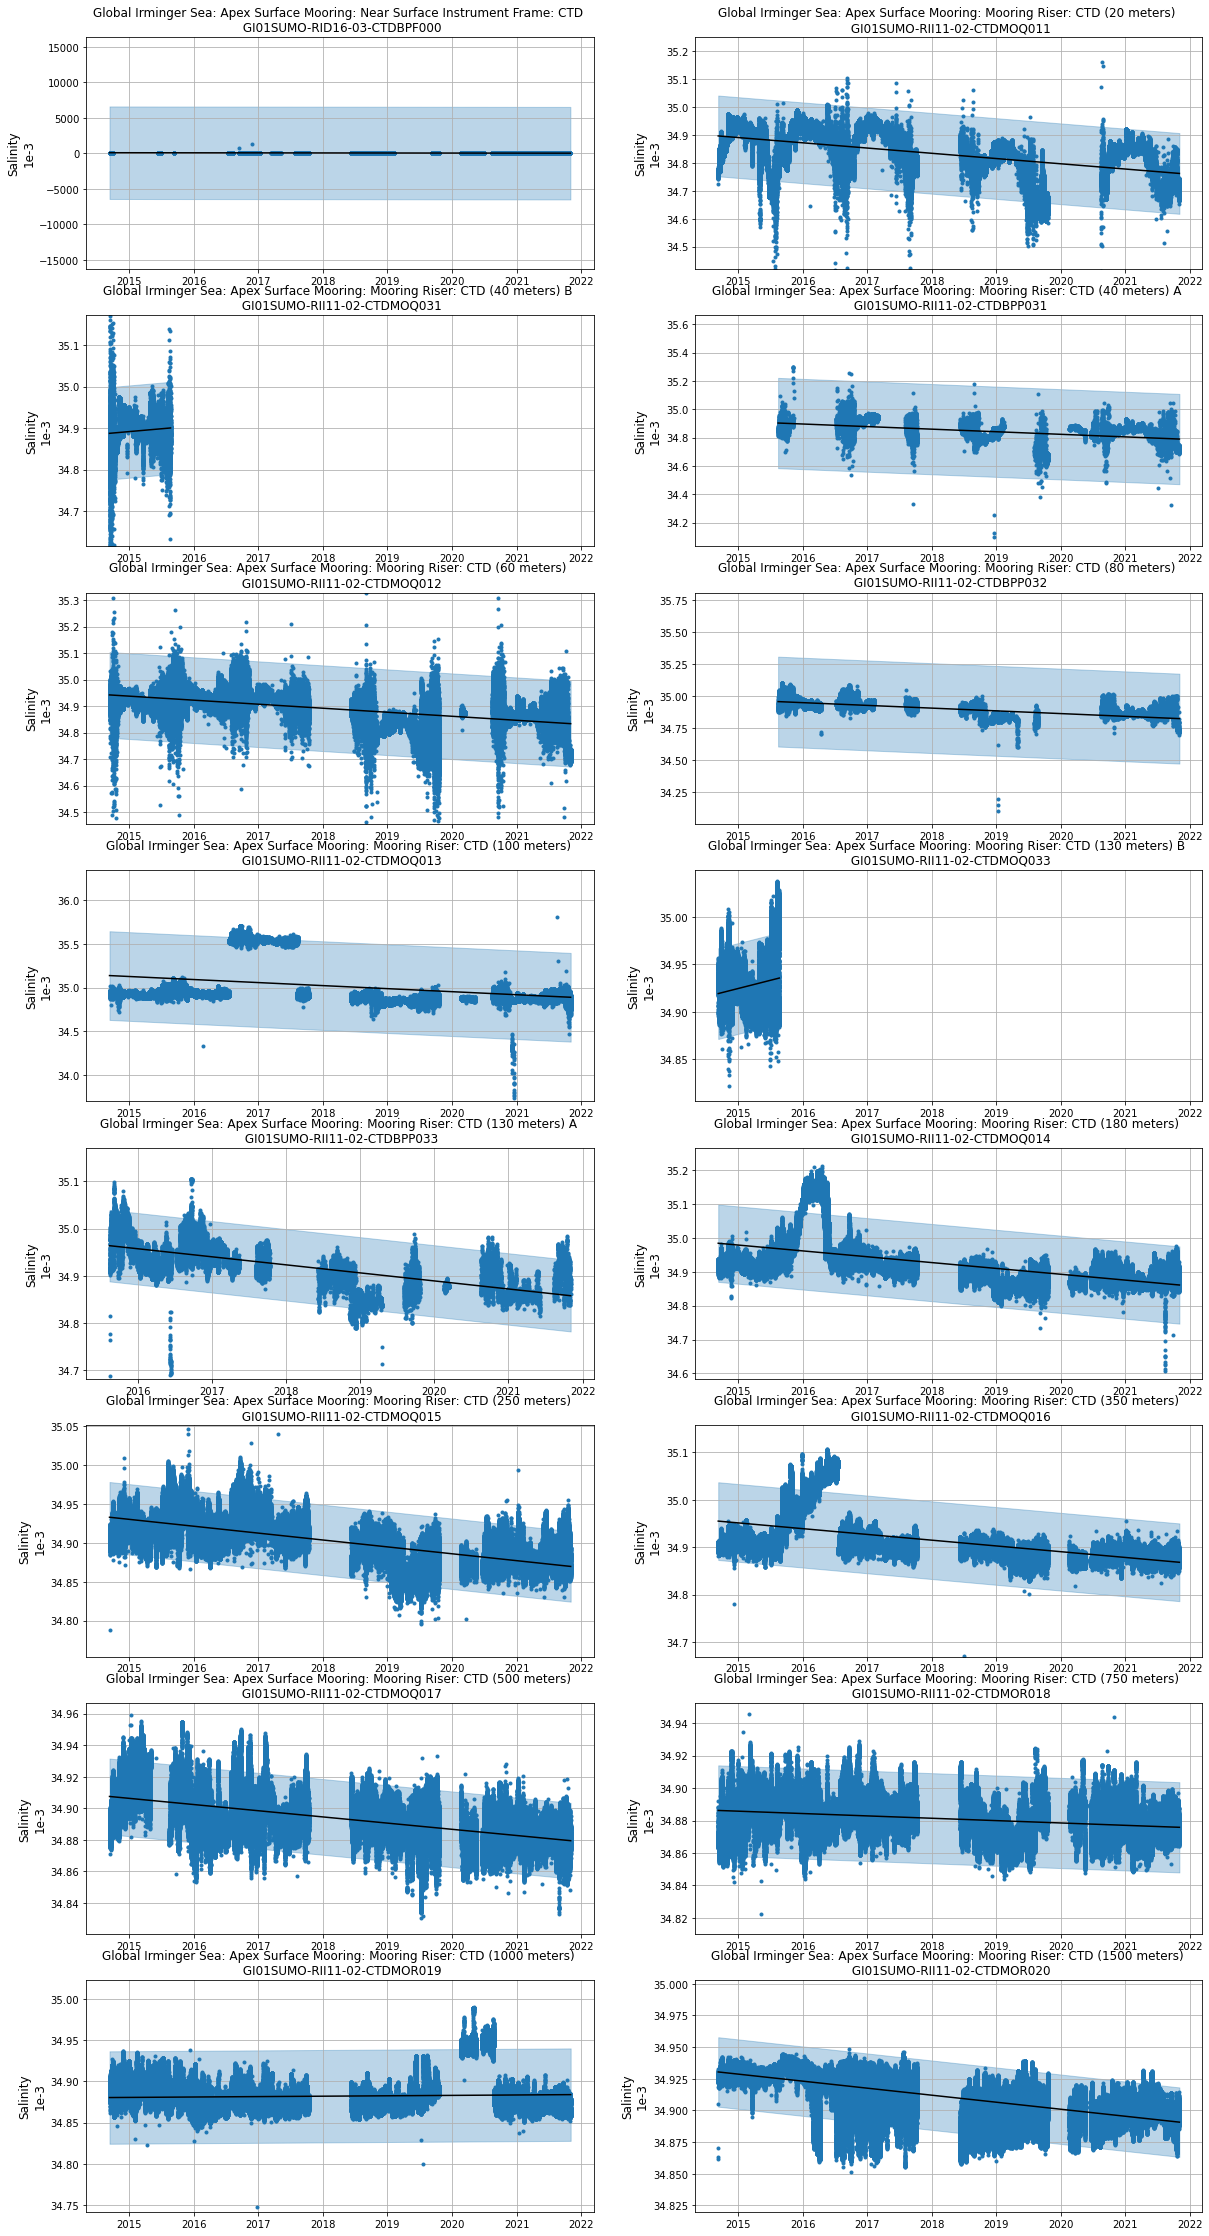

In [29]:
param = "sea_water_practical_salinity"
color = "tab:blue"
nfigs = len(gi01sumo.keys())
xmin, xmax = None, None
# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(nrows=int(np.ceil(nfigs/2)), ncols=2, figsize=(20, 5*nrows))

for k, refdes in enumerate(gi01sumo.keys()):
    row, col = int(np.floor(k/2)), int(k % 2)
    data = gi01sumo.get(refdes)
    data = data.dropna(dim="time", subset=[param])
    yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    # Calculate the regression to fit
    regression = LinearRegression()
    X = (data["time"] - data["time"][0]).astype(float).values.reshape(-1, 1)
    y = data[param].values.reshape(-1,1)
    regression.fit(X, y)
    yhat = regression.predict(X)
    yhat_std = calculate_std(y, yhat)
    # Plot the data
    ax[row, col].plot(data["time"], data[param], marker=".", linestyle="", color=color)
    ax[row, col].set_ylabel(data[param].attrs["long_name"] + "\n" + data[param].attrs["units"], fontsize=12)
    # Add in the regression
    ax[row, col].plot(data["time"], yhat, color="black")
    ax[row, col].fill_between(data["time"], yhat.flatten()-2*yhat_std, yhat.flatten()+2*yhat_std, color=color, alpha=0.3)
    ax[row, col].set_title(data.attrs["title"] + " \n " + refdes)
    ax[row, col].set_ylim(ymin, ymax)
    ax[row, col].grid()
    xmin_k, xmax_k = ax[row, col].get_xlim()
    if xmin is None or xmin_k < xmin:
        xmin = xmin_k
    if xmax is None or xmax_k > xmax:
        xmax = xmax_k
    
# Set uniform xgrid
for k in np.arange(0, len(ax), 1):
    row, col = int(np.floor(k/2)), int(k % 2)
    ax[row, col].set_xlim(xmin, xmax)
    
#fig.autofmt_xdate()

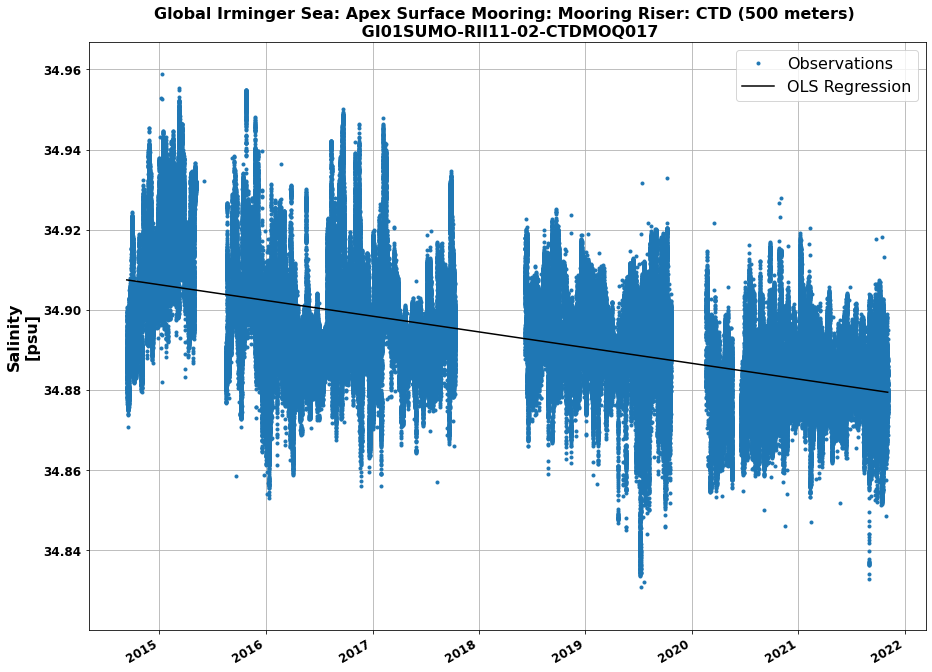

In [41]:
refdes = "GI01SUMO-RII11-02-CTDMOQ017"
param = "sea_water_practical_salinity"
color = "tab:blue"

# Get the data
data = gi01sumo.get(refdes)
data = data.dropna(dim="time", subset=[param])

# Calculate the regression to fit
regression = LinearRegression()
X = (data["time"] - data["time"][0]).astype(float).values.reshape(-1, 1)
y = data[param].values.reshape(-1,1)
regression.fit(X, y)
yhat = regression.predict(X)
yhat_std = calculate_std(y, yhat)

# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(figsize=(15, 12))

# Set plotting limits
yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
ymin, ymax = yavg-5*ystd, yavg+5*ystd

# Plot the data
ax.plot(data["time"], data[param], marker=".", linestyle="", color=color, label="Observations")

# Add in the regression
ax.plot(data["time"], yhat, color="black", label="OLS Regression")
#ax.fill_between(data["time"], yhat.flatten()-2*yhat_std, yhat.flatten()+2*yhat_std, color=color, alpha=0.3, label="Regression 2$\sigma$")

# Add in figure labels, legend, etc.
if "sal" in param:
    units = "[psu]"
else:
    units = data[param].attrs["units"]
ax.set_ylabel(data[param].attrs["long_name"] + "\n" + units, fontsize=16, weight="bold")
ax.legend(fontsize=16)
ax.set_title(data.attrs["title"] + " \n " + refdes, fontsize=16, weight="bold")
ax.set_ylim(ymin, ymax)
ax.grid()

fig.autofmt_xdate()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [42]:
fig.savefig(f"../results/figures/{refdes}_with_regression.png", facecolor="white", transparent=False)

In [ ]:
saveDir = "../results/figures"
figName = "_".join(("GI01SUMO", "all", "ctds", param))
fig.savefig(f"{saveDir}/{figName}.png")

Plot all of the timeseries on top of each other, using different colors to denote different instruments

In [ ]:
param = "sea_water_temperature"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))

# Set discrete category values
levels, categories = pd.factorize(gi01sumo_datasets['depth'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab20(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")
    
# Plot the data
for k, refdes in enumerate(gi01sumo.keys()):
    # Assign the category based on depth
    depth = int(gi01sumo_datasets[gi01sumo_datasets["refdes"] == refdes]["depth"])
    color = colors[list(categories).index(depth)]
    data = gi01sumo.get(refdes)
    yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    ax.plot(data["time"], data[param], marker=".", linestyle="", markersize=1, color=color, alpha=0.5)

ax.legend(handles=handles, title='Deployed Depth', fontsize=12, edgecolor="black")

#### GI03FLMA

In [43]:
gi03flma = dict.fromkeys(gi03flma_datasets["refdes"])
for refdes in gi03flma_datasets["refdes"]:
    datasets = pd.read_csv(erd.get_search_url(search_for=refdes.lower(), response="csv"))["Dataset ID"]
    dset = datasets.iloc[0]
    erd.dataset_id = dset
    data = erd.to_xarray()
    data = data.swap_dims({"obs":"time"})
    gi03flma[refdes] = data

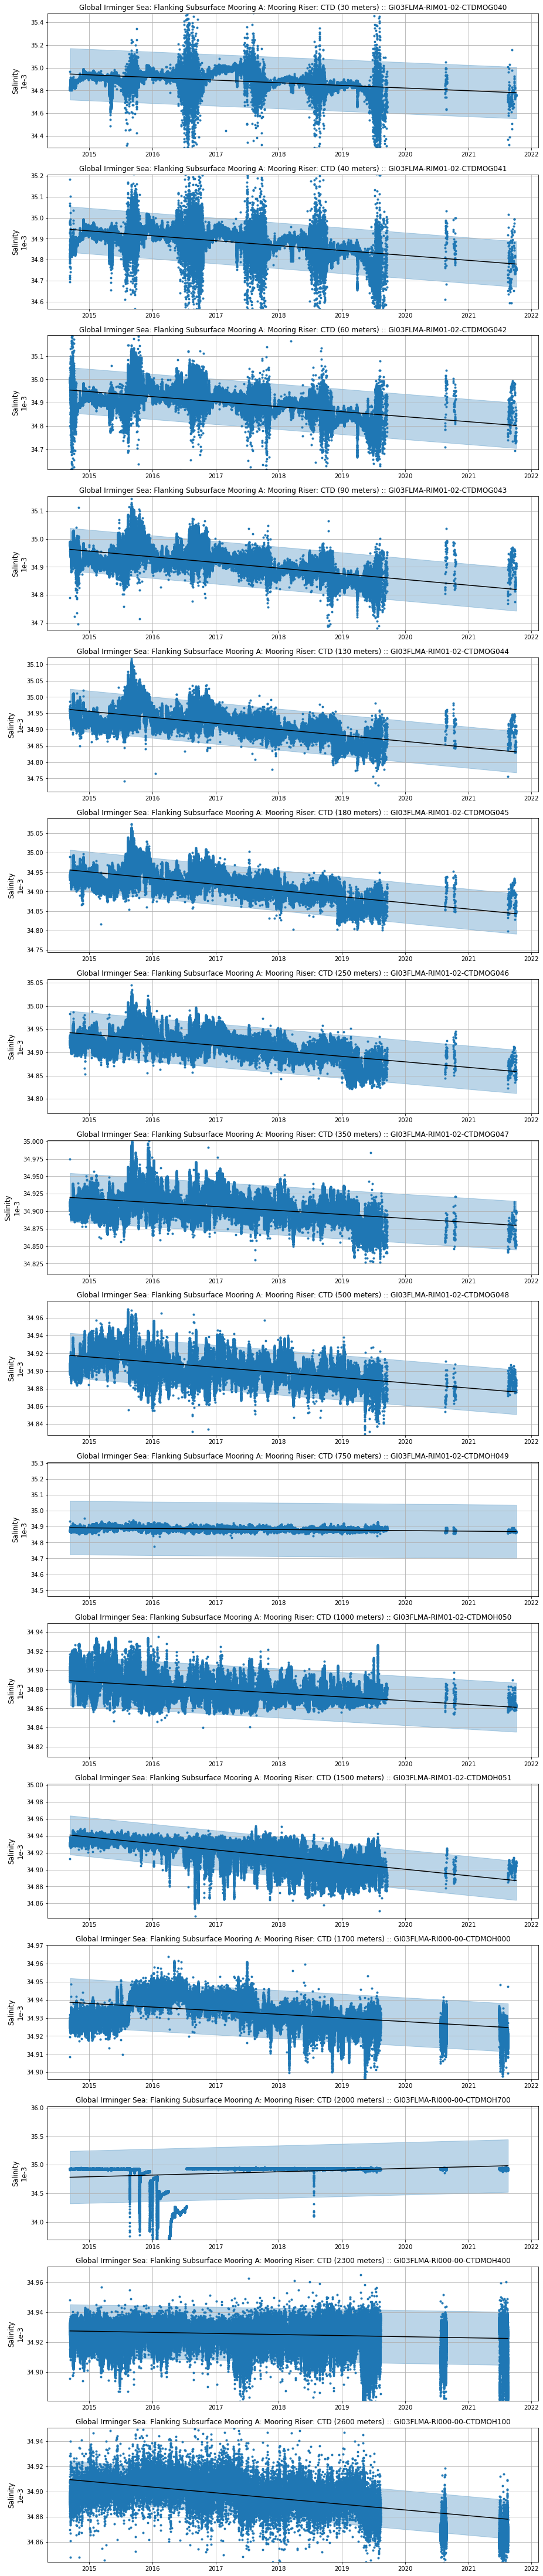

In [44]:
param = "sea_water_practical_salinity"
color = "tab:blue"
nrows = len(gi03flma.keys())
xmin, xmax = None, None
# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 5*nrows))

for k, refdes in enumerate(gi03flma.keys()):
    data = gi03flma.get(refdes)
    # Set the plot limits
    yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    # Calculate the regression to fit
    regression = LinearRegression()
    X = (data["time"] - data["time"][0]).astype(float).values.reshape(-1, 1)
    y = data[param].values.reshape(-1,1)
    regression.fit(X, y)
    yhat = regression.predict(X)
    yhat_std = calculate_std(y, yhat)
    # Plot the data
    ax[k].plot(data["time"], data[param], marker=".", linestyle="", color=color)
    ax[k].set_ylabel(data[param].attrs["long_name"] + "\n" + data[param].attrs["units"], fontsize=12)
    ax[k].set_title(data.attrs["title"] + " :: " + refdes)
    ax[k].set_ylim(ymin, ymax)
    ax[k].grid()
    # Add in the regression
    ax[k].plot(data["time"], yhat, color="black")
    ax[k].fill_between(data["time"], yhat.flatten()-2*yhat_std, yhat.flatten()+2*yhat_std, color=color, alpha=0.3)
    xmin_k, xmax_k = ax[k].get_xlim()
    if xmin is None or xmin_k < xmin:
        xmin = xmin_k
    if xmax is None or xmax_k > xmax:
        xmax = xmax_k
    
# Set uniform xgrid
for k in np.arange(0, len(ax), 1):
    ax[k].set_xlim(xmin, xmax)

In [ ]:
saveDir = "../results/figures"
figName = "_".join(("GI03FLMA", "all", "ctds", param))
fig.savefig(f"{saveDir}/{figName}.png")

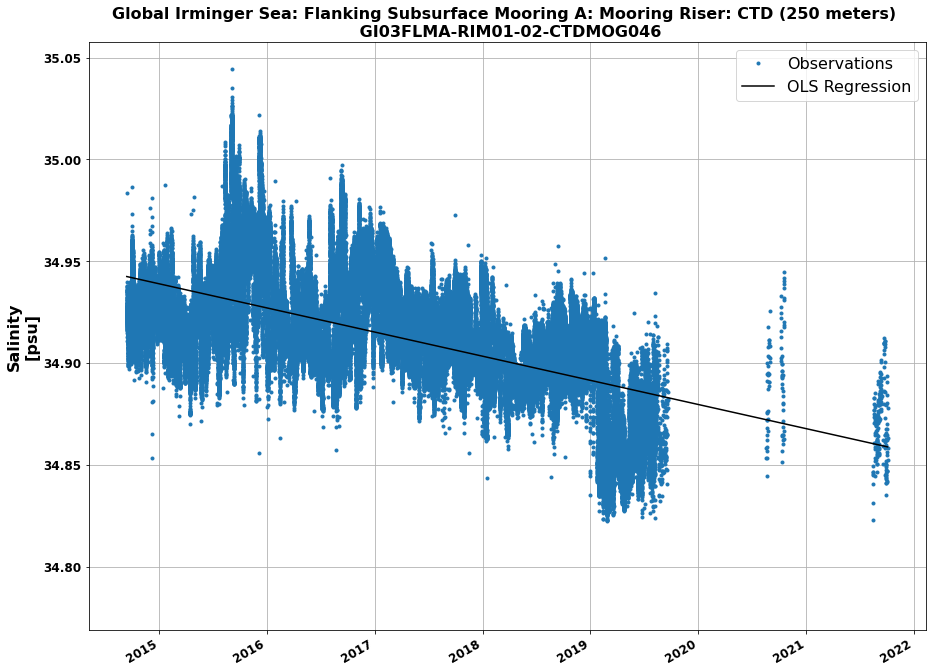

In [46]:
refdes = "GI03FLMA-RIM01-02-CTDMOG046"
param = "sea_water_practical_salinity"
color = "tab:blue"

# Get the data
data = gi03flma.get(refdes)
data = data.dropna(dim="time", subset=[param])

# Calculate the regression to fit
regression = LinearRegression()
X = (data["time"] - data["time"][0]).astype(float).values.reshape(-1, 1)
y = data[param].values.reshape(-1,1)
regression.fit(X, y)
yhat = regression.predict(X)
yhat_std = calculate_std(y, yhat)

# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(figsize=(15, 12))

# Set plotting limits
yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
ymin, ymax = yavg-5*ystd, yavg+5*ystd

# Plot the data
ax.plot(data["time"], data[param], marker=".", linestyle="", color=color, label="Observations")

# Add in the regression
ax.plot(data["time"], yhat, color="black", label="OLS Regression")
#ax.fill_between(data["time"], yhat.flatten()-2*yhat_std, yhat.flatten()+2*yhat_std, color=color, alpha=0.3, label="Regression 2$\sigma$")

# Add in figure labels, legend, etc.
if "sal" in param:
    units = "[psu]"
else:
    units = data[param].attrs["units"]
ax.set_ylabel(data[param].attrs["long_name"] + "\n" + units, fontsize=16, weight="bold")
ax.legend(fontsize=16)
ax.set_title(data.attrs["title"] + " \n " + refdes, fontsize=16, weight="bold")
ax.set_ylim(ymin, ymax)
ax.grid()

fig.autofmt_xdate()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [47]:
fig.savefig(f"../results/figures/{refdes}_with_regression.png", facecolor="white", transparent=False)

#### GA03FLMB

In [48]:
gi03flmb = dict.fromkeys(gi03flmb_datasets["refdes"])
for refdes in gi03flmb_datasets["refdes"]:
    datasets = pd.read_csv(erd.get_search_url(search_for=refdes.lower(), response="csv"))["Dataset ID"]
    dset = datasets.iloc[0]
    erd.dataset_id = dset
    data = erd.to_xarray()
    data = data.swap_dims({"obs":"time"})
    gi03flmb[refdes] = data

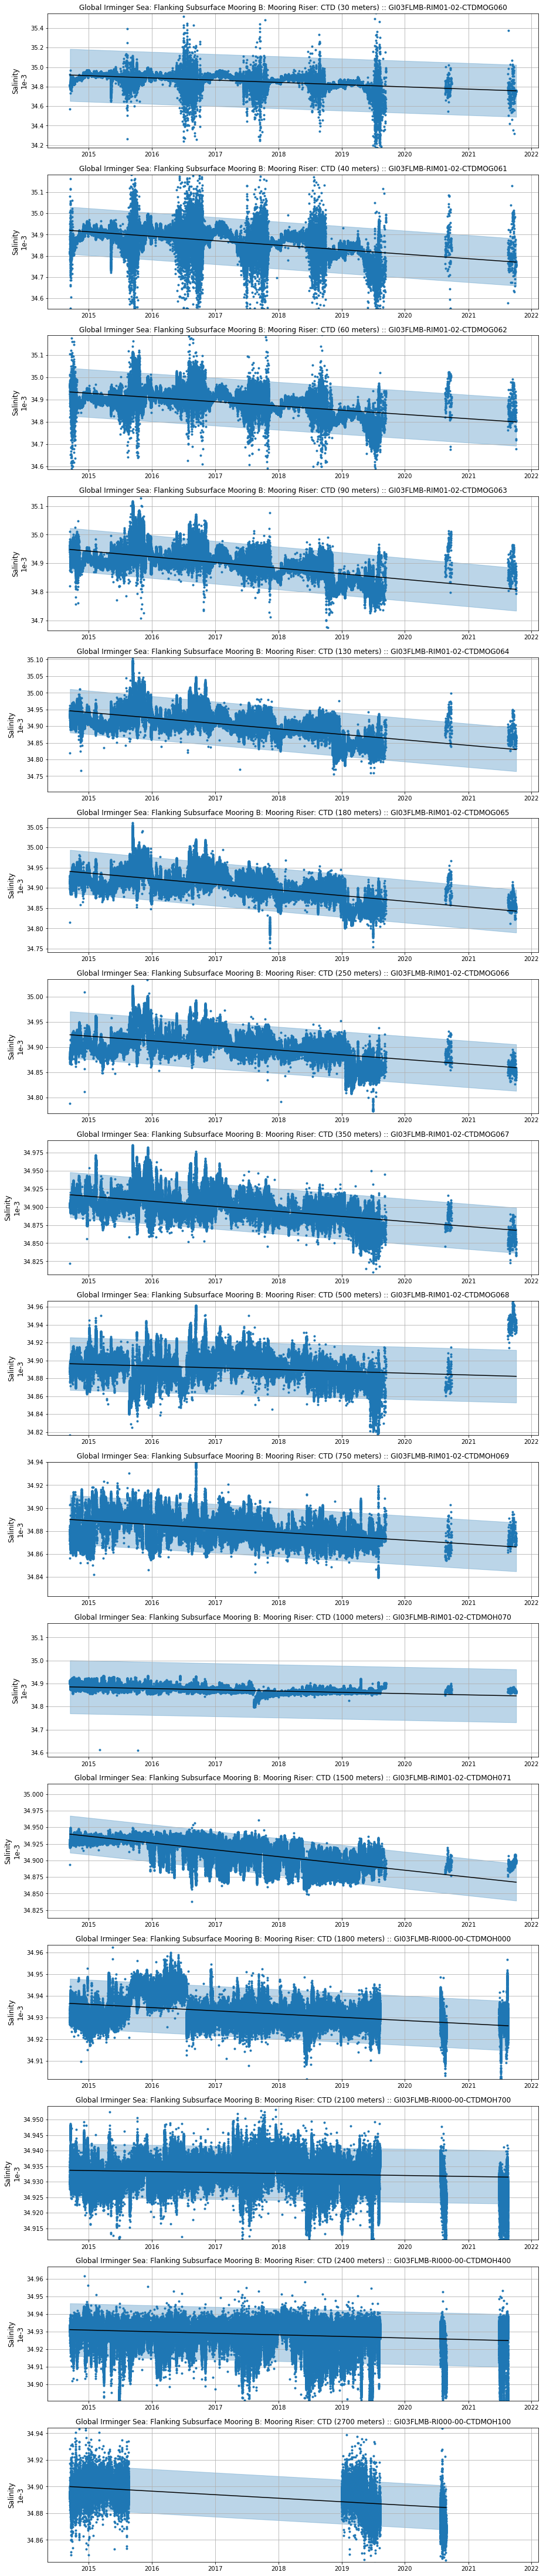

In [49]:
param = "sea_water_practical_salinity"
color = "tab:blue"
nrows = len(gi03flmb.keys())
xmin, xmax = None, None
# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 5*nrows))

for k, refdes in enumerate(gi03flmb.keys()):
    data = gi03flmb.get(refdes)
    yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    # Calculate the regression to fit
    regression = LinearRegression()
    X = (data["time"] - data["time"][0]).astype(float).values.reshape(-1, 1)
    y = data[param].values.reshape(-1,1)
    regression.fit(X, y)
    yhat = regression.predict(X)
    yhat_std = calculate_std(y, yhat)
    # Plot the data
    ax[k].plot(data["time"], data[param], marker=".", linestyle="", color=color)
    ax[k].set_ylabel(data[param].attrs["long_name"] + "\n" + data[param].attrs["units"], fontsize=12)
    ax[k].set_title(data.attrs["title"] + " :: " + refdes)
    ax[k].set_ylim(ymin, ymax)
    ax[k].grid()
    # Add in the regression
    ax[k].plot(data["time"], yhat, color="black")
    ax[k].fill_between(data["time"], yhat.flatten()-2*yhat_std, yhat.flatten()+2*yhat_std, color=color, alpha=0.3)
    xmin_k, xmax_k = ax[k].get_xlim()
    if xmin is None or xmin_k < xmin:
        xmin = xmin_k
    if xmax is None or xmax_k > xmax:
        xmax = xmax_k
    
# Set uniform xgrid
for k in np.arange(0, len(ax), 1):
    ax[k].set_xlim(xmin, xmax)

In [ ]:
saveDir = "../results/figures"
figName = "_".join(("GI03FLMB", "all", "ctds", param))
fig.savefig(f"{saveDir}/{figName}.png")

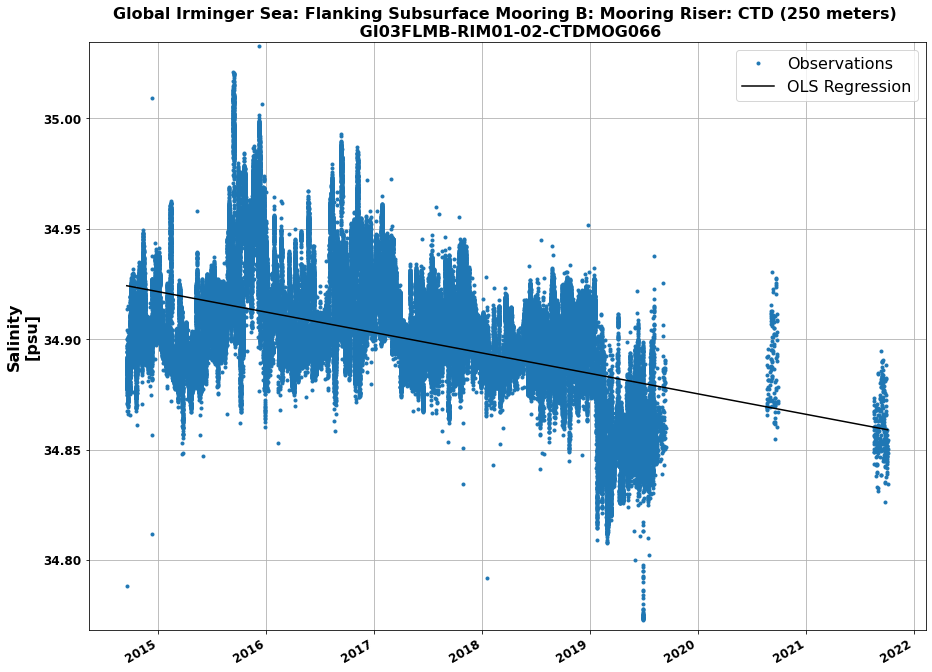

In [51]:
refdes = "GI03FLMB-RIM01-02-CTDMOG066"
param = "sea_water_practical_salinity"
color = "tab:blue"

# Get the data
data = gi03flmb.get(refdes)
data = data.dropna(dim="time", subset=[param])

# Calculate the regression to fit
regression = LinearRegression()
X = (data["time"] - data["time"][0]).astype(float).values.reshape(-1, 1)
y = data[param].values.reshape(-1,1)
regression.fit(X, y)
yhat = regression.predict(X)
yhat_std = calculate_std(y, yhat)

# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(figsize=(15, 12))

# Set plotting limits
yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
ymin, ymax = yavg-5*ystd, yavg+5*ystd

# Plot the data
ax.plot(data["time"], data[param], marker=".", linestyle="", color=color, label="Observations")

# Add in the regression
ax.plot(data["time"], yhat, color="black", label="OLS Regression")
#ax.fill_between(data["time"], yhat.flatten()-2*yhat_std, yhat.flatten()+2*yhat_std, color=color, alpha=0.3, label="Regression 2$\sigma$")

# Add in figure labels, legend, etc.
if "sal" in param:
    units = "[psu]"
else:
    units = data[param].attrs["units"]
ax.set_ylabel(data[param].attrs["long_name"] + "\n" + units, fontsize=16, weight="bold")
ax.legend(fontsize=16)
ax.set_title(data.attrs["title"] + " \n " + refdes, fontsize=16, weight="bold")
ax.set_ylim(ymin, ymax)
ax.grid()

fig.autofmt_xdate()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [52]:
fig.savefig(f"../results/figures/{refdes}_with_regression.png", facecolor="white", transparent=False)

Based on the grid search across the 

In [ ]:
#param = "sea_water_temperature"
param = "sea_water_practical_salinity"

In [ ]:
# Set the colors
arrays = ["FLMA", "FLMB", "SUMO"]
levels, categories = pd.factorize(arrays)
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data 
for depth in gi03flma_datasets["depth"]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))

    # ----------------------------------------------------------
    # Flanking Mooring A
    flma = gi03flma_datasets[gi03flma_datasets["depth"] == depth]["refdes"].values[0]
    flma_data = gi03flma.get(flma)
    # Plot the flma data
    ax.plot(flma_data["time"], flma_data[param], linestyle="", marker=".", color=colors[0], alpha=0.7)
    yavg, ystd = flma_data[param].mean(skipna=True), flma_data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    
    # ----------------------------------------------------------
    # Flanking Mooring B
    flmb = gi03flmb_datasets[gi03flmb_datasets["depth"] == depth]["refdes"].values[0]
    flmb_data = gi03flmb.get(flmb)
    # Plot the flma data
    ax.plot(flmb_data["time"], flmb_data[param], linestyle="", marker=".", color=colors[1], alpha=0.7)
    
    # ----------------------------------------------------------
    # Surface Mooring
    try:
        sumo = gi01sumo_datasets[gi01sumo_datasets["depth"] == depth]["refdes"].values[0]
        sumo_data = gi01sumo.get(sumo)
        # Plot the flma data
        ax.plot(sumo_data["time"], sumo_data[param], linestyle="", marker=".", color=colors[2], alpha=0.7)
    except:
        sumo = None
        
    # ----------------------------------------------------------
    # Set the figure
    ax.grid()
    ax.set_ylabel(flma_data[param].attrs["long_name"] + "\n" + flma_data[param].attrs["units"], fontsize=16)
    #if depth >= 500:
    ax.set_ylim(ymin, ymax)
    ax.legend(handles=handles, title='Array', fontsize=12, edgecolor="black")
    ax.set_title(f"CTD Data at {int(depth)}m", fontsize=16)
    fig.autofmt_xdate()

In [ ]:
saveDir = "../results/figures"
figName = "_".join((refdes, "time", "series"))
fig.savefig(f"{saveDir}/{figName}.png")

### Add Deployment Information
Datasets downloaded from Data Explorer do not come with the deployment information as a data variable, unlike datasets downloaded from the OOI Data Portal (https://ooinet.oceanobservatories.org). Here, we step through adding deployment information to the ERDDAP dataset by requesting the deployment times from the Data Portal via the OOI API.

In [53]:
for refdes in gi01sumo:
    # Get the deployment info for the given reference designator
    deployments = OOINet.get_deployments(refdes)
    
    # Get the dataset
    data = gi01sumo.get(refdes)

    # Add the deployment info to the dataset
    d = xr.DataArray(data=np.zeros, dims=data["time"].dims, coords=data["time"].coords, name="deployment")
    for depNum in sorted(deployments["deploymentNumber"]):
        # Get the start and end times of the deployments
        deployStart = deployments[deployments["deploymentNumber"] == depNum]["deployStart"].values[0]
        deployEnd = deployments[deployments["deploymentNumber"] == depNum]["deployEnd"].values[0]
        # Add in the deployment number
        d[(d.time >= deployStart) & (d.time <= deployEnd)] = depNum
        
    data[d.name] = d

In [54]:
for refdes in gi03flma:
    # Get the deployment info for the given reference designator
    deployments = OOINet.get_deployments(refdes)
    
    # Get the dataset
    data = gi03flma.get(refdes)

    # Add the deployment info to the dataset
    d = xr.DataArray(data=np.zeros, dims=data["time"].dims, coords=data["time"].coords, name="deployment")
    for depNum in sorted(deployments["deploymentNumber"]):
        # Get the start and end times of the deployments
        deployStart = deployments[deployments["deploymentNumber"] == depNum]["deployStart"].values[0]
        deployEnd = deployments[deployments["deploymentNumber"] == depNum]["deployEnd"].values[0]
        # Add in the deployment number
        d[(d.time >= deployStart) & (d.time <= deployEnd)] = depNum
        
    data[d.name] = d

In [55]:
for refdes in gi03flmb:
    # Get the deployment info for the given reference designator
    deployments = OOINet.get_deployments(refdes)
    
    # Get the dataset
    data = gi03flmb.get(refdes)

    # Add the deployment info to the dataset
    d = xr.DataArray(data=np.zeros, dims=data["time"].dims, coords=data["time"].coords, name="deployment")
    for depNum in sorted(deployments["deploymentNumber"]):
        # Get the start and end times of the deployments
        deployStart = deployments[deployments["deploymentNumber"] == depNum]["deployStart"].values[0]
        deployEnd = deployments[deployments["deploymentNumber"] == depNum]["deployEnd"].values[0]
        # Add in the deployment number
        d[(d.time >= deployStart) & (d.time <= deployEnd)] = depNum
        
    data[d.name] = d

### Clean up dataset
Before we go any farther, going to clean up the downloaded data set. First, going to dump all the passed "qc_tests" in the dataset. We're doing this in order to be able to see for ourselves how these are calculated

In [18]:
# Remove the QC variables from the existing datasets
for refdes in gi01sumo.keys():
    data = gi01sumo.get(refdes)
    for var in data.variables:
        if "qc" in var:
            data = data.drop(var)
    gi01sumo[refdes] = data

Next, we need to filter out obviously bad data. There is a bug in the IOOS_QC QARTOD climatology code which raises an ValueError if data is outside of the fail_span. Consequently, we need to drop that data from the datasets. This is obviously not an ideal approach - ideally you'd keep this data, but for our purposes here we're going streamline the process

In [59]:
parameters = ["sea_water_practical_salinity", "sea_water_temperature"]

for refdes in gi01sumo:
    data = gi01sumo.get(refdes)
    for param in parameters:
        if param == "sea_water_temperature":
            fail_min, fail_max = (-5, 35)
            data = data.where((data[param] > fail_min) & (data[param] < fail_max), drop=True)
        elif param == "sea_water_practical_salinity":
            fail_min, fail_max = (0, 42)
            data = data.where((data[param] > fail_min) & (data[param] < fail_max), drop=True)
        else:
            pass
    gi01sumo[refdes] = data


---
## QARTOD
First, calculate the gross range of the time series with respect to the salinity and temperature

In [60]:
from qartod.gross_range import GrossRange
from qartod.climatology import Climatology
from ioos_qc.config import QcConfig, ContextConfig, Config
from ioos_qc.qartod import gross_range_test, climatology_test, ClimatologyConfig

In [61]:
def add_qartod_test(data, param, test, test_results):
    # Generate the test name
    testName = "_".join((param, "qartod", test))
    
    # Create an xarray DataArray of the test_results
    test_results = xr.DataArray(
        data=test_results,
        dims=data[param].dims,
        coords=data[param].coords,
    )
    
    data[testName] = test_results
    return data

In [62]:
def aggregate_results(data, param):
    """Aggregate the results of all qartod tests for a given parameter"""
    # Get the qartod variables
    qartod_vars = []
    for var in data:
        if (param in var) & ("qartod" in var):
            qartod_vars.append(var)
            
    # Aggregate and take max flag
    aggregate = np.vstack((data[v] for v in qartod_vars))
    aggregate = aggregate.max(axis=0)
    return aggregate

In [63]:
# Parameters and tests to run for QARTOD flaggins
parameters = ["sea_water_practical_salinity", "sea_water_temperature"]
tests = ["gross_range", "climatology"]

# Initialize an empty dictionary to hold the results of the QARTOD tests
results = dict.fromkeys(gi01sumo.keys())
for refdes in results.keys():
    refdes_results = dict.fromkeys(parameters)
    for key in refdes_results.keys():
        refdes_results[key] = dict.fromkeys(tests, {})
    results[refdes] = refdes_results

#### Calculate QARTOD Flags


In [64]:
for refdes in results.keys():
    # Get the data
    data = gi01sumo.get(refdes)
    # Iterate through the parameters and tests to calculate the QARTOD flags
    parameters = results.get(refdes).keys()
    for param in parameters:
        # Set fail spans
        if param == "sea_water_temperature":
            fail_span = (-5, 35)
        elif param == "sea_water_practical_salinity":
            fail_span = (0, 42)
        else:
            raise TypeError(f"Param {param} not found.")
        # Iterate through the tests
        for test in tests:
            if test == "gross_range":
                # Calculate the gross range ranges
                fail_min, fail_max = fail_span
                gross_range = GrossRange(fail_min, fail_max)
                gross_range.fit(data, param)
                # Run the gross range test
                test_results = gross_range_test(
                    inp=data[param],
                    fail_span=(gross_range.fail_min, gross_range.fail_max),
                    suspect_span=(gross_range.suspect_min, gross_range.suspect_max)
                )
                # Save the fit results
                results[refdes][param][test] = gross_range
            elif test == "climatology":
                # Calculate the gross range ranges
                climatology = Climatology()
                climatology.fit(data, param, fail_span=fail_span)
                # Make the climatology config objecty
                c = ClimatologyConfig()
                for ind in climatology.monthly_fit.index:
                    vmin = np.floor((climatology.monthly_fit.loc[ind] - 2*climatology.monthly_std.loc[ind])*100)/100
                    vmax = np.ceil((climatology.monthly_fit.loc[ind] + 2*climatology.monthly_std.loc[ind])*100)/100
                    c.add(tspan=[ind, ind],
                          vspan=[vmin, vmax],
                          fspan=[fail_span[0], fail_span[1]],
                          zspan=[0,5000],
                          period="month")
                # Run the climatology test
                test_results = climatology_test(c,
                                    inp=data[param],
                                    tinp=data["time"],
                                    zinp=data["sea_water_pressure"]
                                    )
                # Save the fit results
                results[refdes][param][test] = climatology
            else:
                print(f"Error with test {test} for param {param}")
            # Save the results
            data = add_qartod_test(data, param, test, test_results)
            
        # Now add the aggregate flag for the given parameter
        aggregate = aggregate_results(data, param)
        data = add_qartod_test(data, param, "aggregate", aggregate)
        
    # Store the data in the data dictionary
    gi01sumo[refdes] = data

In [65]:
def plot_climatology(data, param, climatology, **kwargs):
    
    # Check the kwargs
    if "color" in kwargs.keys():
        color = kwargs.get("color")
    else:
        color = "tab:red"
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Plot the Observations
    ax.plot(data.time, data[param], marker=".", linestyle="", color=color, zorder=0, label="Observations")
    yavg, ystd = np.mean(data[param]), np.std(data[param])
    ymin, ymax = yavg-ystd*7, yavg+ystd*7
    ax.set_ylim((ymin, ymax))
    
    # Standard Deviation +/- 3
    for t in climatology.fitted_data.index:
        t0 = pd.Timestamp(year=t.year, month=t.month, day=1)
        mu = climatology.monthly_fit.loc[t.month]
        std = climatology.monthly_std.loc[t.month]
        ax.hlines(mu, t0, t, color="black", linewidth=3, label="Climatological Fit")
        ax.fill_between([t0, t], [mu+2*std, mu+2*std], [mu-2*std, mu-2*std], color=color, alpha=0.3, label="2*$\sigma$")

    
    # Add legend and labels
    handles, labels = ax.get_legend_handles_labels()[0][0:3], ax.get_legend_handles_labels()[1][0:3]
    ax.legend(handles, labels, fontsize=12)
    ax.set_title(data.attrs["platform_name"], fontsize=16)
    ax.set_ylabel(data[param].attrs["long_name"], fontsize=16)
    ax.grid()
    fig.autofmt_xdate()
    
    return fig, ax

In [66]:
def plot_gross_range(data, param, gross_range, **kwargs):
    
    # Check the kwargs
    if "color" in kwargs.keys():
        color = kwargs.get("color")
    else:
        color = "tab:red"
        
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Plot the Observations
    ax.plot(data.time, data[param], marker=".", linestyle="", color=color, zorder=0, label="Observations")
    yavg, ystd = np.mean(data[param]), np.std(data[param])
    ymin, ymax = yavg-ystd*7, yavg+ystd*7    
    ax.set_ylim((ymin, ymax))
    xmin, xmax = ax.get_xlim()
    
    # Plot the gross range fail min/fail max
    fail_min, fail_max = gross_range.fail_min, gross_range.fail_max
    ax.hlines(fail_min, xmin, xmax, colors="black")
    ax.hlines(fail_max, xmin, xmax, colors="black")
    
    # Plot the suspect range
    suspect_min, suspect_max = gross_range.suspect_min, gross_range.suspect_max
    ax.fill
    return fig, ax

In [67]:
def plot_gross_range(ds, param, gross_range):
    """Plot the data with the associated climatology values.

    Parameters
    ----------
    ds: (xarray.Dataset)
        An xarray dataset downloaded from OOINet
    param: (str)
        The parameter name of the data variable in the OOI
        dataset to plot.
    gross_range: (qartod.gross_range object)
        An object containing the calculated gross_range values
        for the associated dataset and variable
        
    Returns
    -------
    fig, ax: (matplotlib figs)
        Figure and axis handles for the matplotlib image
    """
    # Initialize the data
    fig, ax = plt.subplots(figsize=(12, 8))

    # Scatter plot the data
    ax.plot(ds.time, ds[param], linestyle="", marker=".", color="tab:red", zorder=10)
    xmin, xmax = ax.get_xlim()
    ax.fill_between(ds.time, gross_range.suspect_min, gross_range.suspect_max, color="tab:red", alpha=0.3, zorder=5)
    # Add in the gross range mean
    avg = (gross_range.suspect_max+gross_range.suspect_min)/2
    tmin = ds.time.min().values
    tmax = ds.time.max().values
    ax.plot([tmin, tmax], [avg, avg], color="black", zorder=20)
    
    yavg, ystd = ds[param].mean(), ds[param].std()
    ax.set_ylim(yavg-7*ystd, yavg+7*ystd)
    ax.grid()
    ax.set_ylabel(ds[param].attrs["long_name"])
    ax.set_title(ds.attrs["platform_name"])
    
    return fig, ax

In [68]:
gi03flmb.keys()

dict_keys(['GI03FLMB-RIM01-02-CTDMOG060', 'GI03FLMB-RIM01-02-CTDMOG061', 'GI03FLMB-RIM01-02-CTDMOG062', 'GI03FLMB-RIM01-02-CTDMOG063', 'GI03FLMB-RIM01-02-CTDMOG064', 'GI03FLMB-RIM01-02-CTDMOG065', 'GI03FLMB-RIM01-02-CTDMOG066', 'GI03FLMB-RIM01-02-CTDMOG067', 'GI03FLMB-RIM01-02-CTDMOG068', 'GI03FLMB-RIM01-02-CTDMOH069', 'GI03FLMB-RIM01-02-CTDMOH070', 'GI03FLMB-RIM01-02-CTDMOH071', 'GI03FLMB-RI000-00-CTDMOH000', 'GI03FLMB-RI000-00-CTDMOH700', 'GI03FLMB-RI000-00-CTDMOH400', 'GI03FLMB-RI000-00-CTDMOH100'])

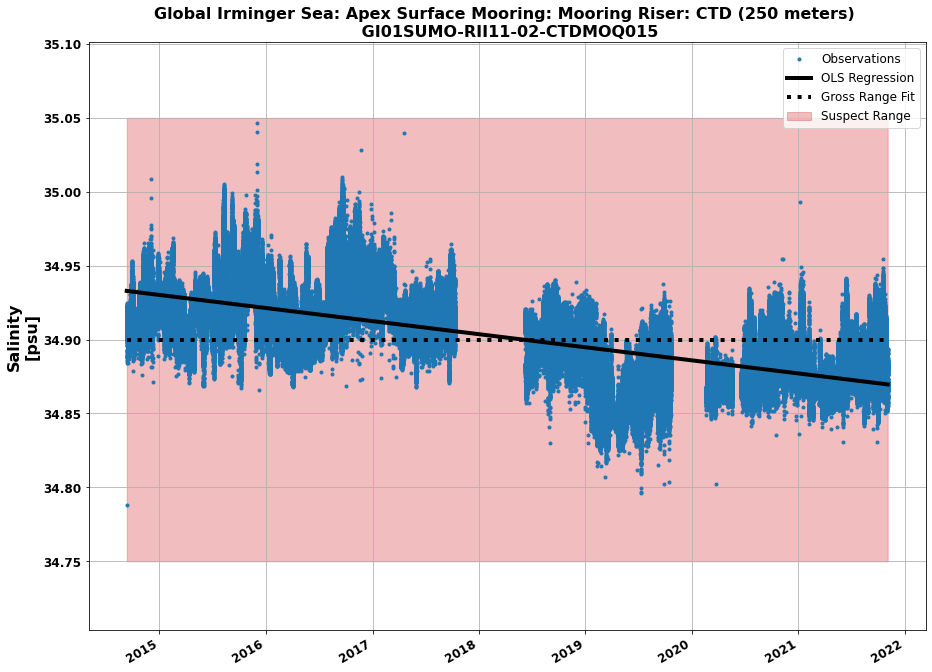

In [75]:
# Plot gross range results against regression and the observations
refdes = "GI01SUMO-RII11-02-CTDMOQ015"
param = "sea_water_practical_salinity"
test_results = results[refdes][param]["gross_range"]
color = "tab:blue"

# Get the data
data = gi01sumo.get(refdes)
data = data.dropna(dim="time", subset=[param])

# Calculate the regression to fit
regression = LinearRegression()
X = (data["time"] - data["time"][0]).astype(float).values.reshape(-1, 1)
y = data[param].values.reshape(-1,1)
regression.fit(X, y)
yhat = regression.predict(X)
yhat_std = calculate_std(y, yhat)

# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(figsize=(15, 12))

# Set plotting limits
yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
ymin, ymax = yavg-5*ystd, yavg+5*ystd

# Plot the data
ax.plot(data["time"], data[param], marker=".", linestyle="", color=color, label="Observations")

# Add in the regression
ax.plot(data["time"], yhat, color="black", linewidth=4, label="OLS Regression")
#ax.fill_between(data["time"], yhat.flatten()-2*yhat_std, yhat.flatten()+2*yhat_std, color=color, alpha=0.3, label="Regression 2$\sigma$")

# Add in the gross range
avg = (test_results.suspect_max+test_results.suspect_min)/2
tmin = data.time.min().values
tmax = data.time.max().values
# Add in the gross range mean
ax.fill_between(data.time, test_results.suspect_min, test_results.suspect_max, 
                color="tab:red", alpha=0.3, label="Suspect Range")
ax.plot([tmin, tmax], [avg, avg], color="black", linestyle=":", linewidth=4, label="Gross Range Fit")

# Add in figure labels, legend, etc.
if "sal" in param:
    units = "[psu]"
else:
    units = data[param].attrs["units"]
ax.set_ylabel(data[param].attrs["long_name"] + "\n" + units, fontsize=16, weight="bold")
ax.legend(fontsize=12)
ax.set_title(data.attrs["title"] + " \n " + refdes, fontsize=16, weight="bold")
ax.set_ylim(ymin-0.05, ymax+0.05)
ax.grid()

fig.autofmt_xdate()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [76]:
fig.savefig(f"../results/figures/{refdes}_{param}_with_regression_and_gross_range.png", facecolor="white", transparent=False)

In [ ]:
results[refdes][param]["gross_range"]

In [ ]:
#Plot the results
param = "sea_water_temperature"

In [ ]:
fig, ax = plot_climatology(data, param, results[refdes][param]["climatology"], color="tab:red")
handles, labels = ax.get_legend_handles_labels()[0][0:3], ax.get_legend_handles_labels()[1][0:3]
ax.legend(handles, labels, fontsize=12, loc="lower right", edgecolor="black")

In [ ]:
saveDir = "../results/figures/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)
fig.savefig(f"{saveDir}/{figName}.png")

In [ ]:
fig, ax = plot_climatology(data, param, results[param]["climatology"], color="tab:red")
#handles, labels = ax.get_legend_handles_labels()
#first_legend.set_bbox_to_anchor((1, 0.7))
#ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

# Plot the flagged data
flagged_data = data.where((data.sea_water_temperature_qartod_climatology == 3), drop=True)
ax.plot(flagged_data.time, flagged_data.sea_water_temperature, linestyle="", marker=".", color="tab:blue", label="Flagged")
handles, labels = ax.get_legend_handles_labels()[0][0:4], ax.get_legend_handles_labels()[1][0:4]
ax.legend(handles, labels, fontsize=12, loc="lower right", edgecolor="black")

In [ ]:
figName = "_".join((refdes, param, test, "with_flags"))
figName

In [ ]:
fig.savefig(f"{saveDir}/{figName}.png")

Plot a histogram, by month, of the climatology-flagged data

In [ ]:
flags = (data.sea_water_practical_salinity_qartod_climatology == 3).resample(time="M").sum()
flags

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.bar(flags.time, flags.values, width=24.0, edgecolor="k", color="tab:blue")
ax.set_ylabel(f"Suspect flag count for\n{flags.name}", fontsize=12)
ax.set_title(refdes, fontsize=16)
ax.grid()

fig.autofmt_xdate()

In [ ]:
data.sea_water_temperature_qartod_climatology.resample(time="M").sum()